In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [34]:
df=pd.read_csv('exchange_rate.csv')

In [35]:
df.columns=df.columns.str.strip().str.lower()

In [19]:
df.columns.tolist()

['date', 'ex_rate']

In [36]:
# Parse date and set index
df['date']=pd.to_datetime(df['date'],dayfirst=True,errors='coerce')
df.dropna(subset=['date'],inplace=True)  # Drop rows where date parsing failed
df.set_index('date',inplace=True)
df=df.asfreq('D')  # Daily frequency
df['ex_rate'].interpolate(method='linear',inplace=True)  # Handle missing values

C:\Users\pujitha tummala\AppData\Local\Temp\ipykernel_8828\1803971831.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ex_rate'].interpolate(method='linear',inplace=True)  # Handle missing values


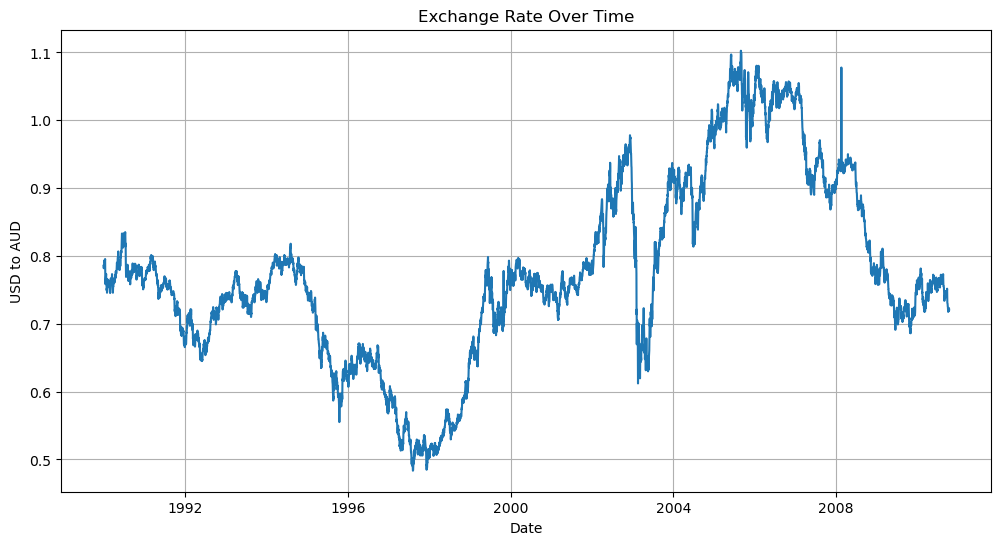

In [37]:
# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(df['ex_rate'])
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('USD to AUD')
plt.grid(True)
plt.show()

In [38]:
# Check stationarity
result=adfuller(df['ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1]<0.05:
    print("Series is stationary.")
else:
    print("Series is NOT stationary. Differencing needed.")

ADF Statistic: -1.664994180738073
p-value: 0.44923273535983155
Series is NOT stationary. Differencing needed.


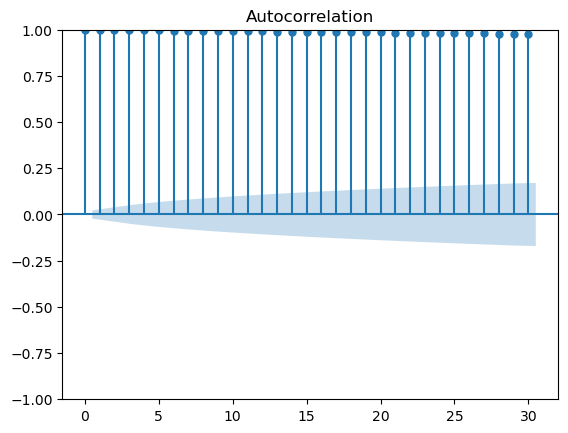

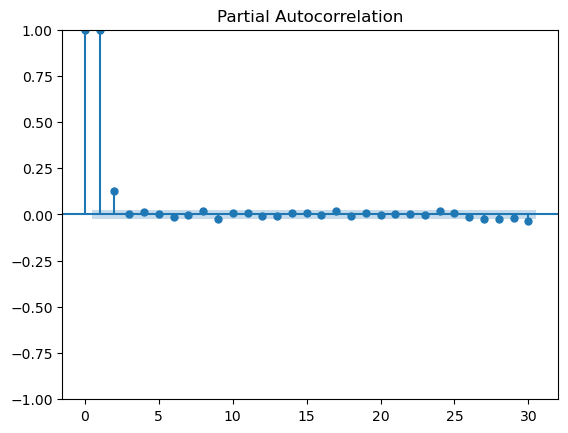

In [39]:
# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['ex_rate'].dropna(),lags=30)
plot_pacf(df['ex_rate'].dropna(),lags=30)
plt.show()

In [40]:
# Fit ARIMA model 
model_arima=ARIMA(df['ex_rate'],order=(1,1,1))
arima_result=model_arima.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 07 May 2025   AIC                         -56102.322
Time:                        11:21:42   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.608      0.0

In [41]:
# Forecast using ARIMA
forecast_steps=30
arima_forecast=arima_result.forecast(steps=forecast_steps)

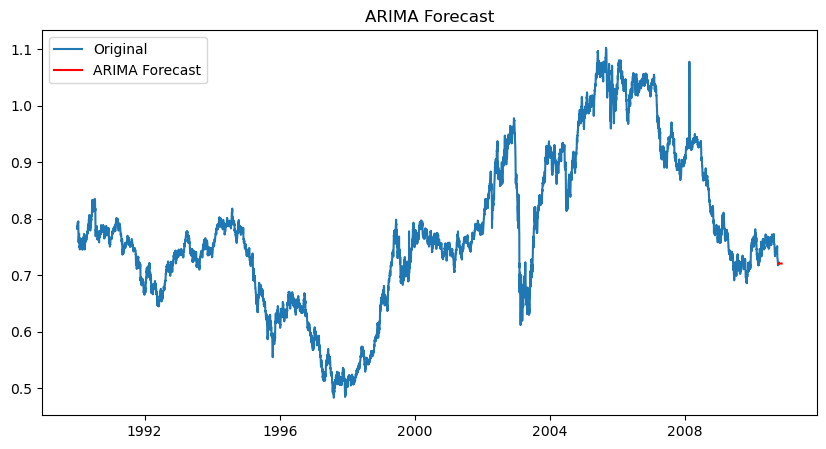

In [42]:
# Plot ARIMA forecast
plt.figure(figsize=(10,5))
plt.plot(df['ex_rate'],label='Original')
plt.plot(pd.date_range(df.index[-1],periods=forecast_steps+1,freq='D')[1:],arima_forecast,label='ARIMA Forecast',color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

In [43]:
# Fit Exponential Smoothing 
hw_model=ExponentialSmoothing(df['ex_rate'],trend='add',seasonal=None)
hw_fit=hw_model.fit()
hw_forecast=hw_fit.forecast(steps=forecast_steps)

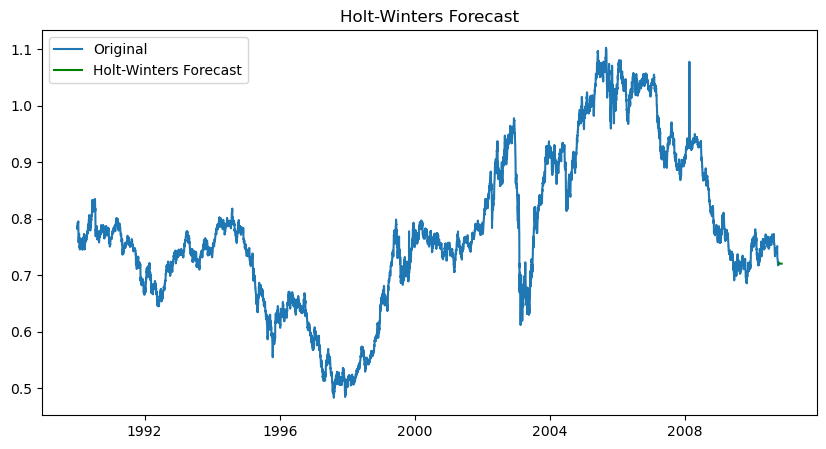

In [44]:
# Plot Holt-Winters forecast
plt.figure(figsize=(10,5))
plt.plot(df['ex_rate'],label='Original')
plt.plot(pd.date_range(df.index[-1],periods=forecast_steps+1,freq='D')[1:],hw_forecast,label='Holt-Winters Forecast',color='green')
plt.legend()
plt.title('Holt-Winters Forecast')
plt.show()

In [45]:
# Evaluation 
if len(df)>60:
    actual=df['ex_rate'][-30:]
    pred_arima=arima_result.predict(start=actual.index[0],end=actual.index[-1])
    pred_hw=hw_fit.predict(start=actual.index[0],end=actual.index[-1])

In [47]:
print("Evaluation on Last 30 Days:")
print("ARIMA MAE:", mean_absolute_error(actual,pred_arima))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(actual,pred_arima)))

Evaluation on Last 30 Days:
ARIMA MAE: 0.0022924310918263266
ARIMA RMSE: 0.003864249147216891


In [48]:
print("HW MAE:", mean_absolute_error(actual,pred_hw))
print("HW RMSE:", np.sqrt(mean_squared_error(actual,pred_hw)))

HW MAE: 0.002299372953566366
HW RMSE: 0.0038633580879255877


In [ ]:
#Both models performed well in capturing the exchange rate trend
#ARIMA was slightly better in accuracy as per error metrics 
#For short-term forecasting, either model could be suitable depending on use case and data characteristics